In [13]:
import numpy as np
import math
import torch
import random
from torch import nn
from sklearn import metrics
import torch
import torch.nn as nn
import numpy as np
from os import path

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import math
import pickle
from tqdm import tqdm
import torch.nn.init
import json
import torch.optim as optim

def variable(tensor, gpu):
    '''
    返回一个可训练的参数
    输入 tensor
    输出 tensor.Variable
    '''
    if gpu >= 0:
        return torch.autograd.Variable(tensor).cuda()
    else:
        return torch.autograd.Variable(tensor)


def to_scalar(var: torch.Tensor):
    '''
    转换为标量 取第一个
    输入 
    '''
    return var.view(-1).data.tolist()[0]


def save_checkpoint(state, track_list, filename):
    '''
    保存模型
    '''
    with open(filename + '.json', 'w') as f:
        json.dump(track_list, f)
    torch.save(state, filename + '.model')


def adjust_learning_rate(optimizer, lr):
    '''
    调整学习率
    '''
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class Param():
    def __init__(self):
        #the number of unique questions in the dataset
        self.n_question = 110
        #the allowed maximum length of a sequence
        self.seqlen = 200
        self.data_dir = "./data/assist2009_updated"
        self.data_name = "assist2009_updated"
        self.q_embed_dim = 50
        self.qa_embed_dim = 200
        self.memory_size = 20
        self.final_fc_dim = 50
        self.batch_size = 32
        self.gpu=-1
        self.lr = init_lr = 0.01
        self.max_iter = 200
        self.maxgradnorm = 50.0
        self.momentum = 0.9
params = Param()

In [14]:
params


In [15]:




def train_with_bh(epoch_num, model, params, optimizer, q_data, qa_data, bh1_data, bh2_data, bh3_data, bh4_data):
    """
    添加行为数据
    """
    N = int(math.floor(len(q_data) / params.batch_size))

    # shuffle_index = np.random.permutation(q_data.shape[0])
    # q_data_shuffled = q_data[shuffle_index]
    # qa_data_shuffled = qa_data[shuffle_index]

    pred_list = []
    target_list = []
    epoch_loss = 0
    model.train()

    # init_memory_value = np.random.normal(0.0, params.init_std, ())
    for idx in range(N):
        q_one_seq = q_data[idx *
                           params.batch_size:(idx + 1) * params.batch_size, :]
        qa_batch_seq = qa_data[idx *
                               params.batch_size:(idx + 1) * params.batch_size, :]
        bh1_batch_seq = bh1_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh2_batch_seq = bh2_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh3_batch_seq = bh3_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh4_batch_seq = bh4_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        target = qa_data[idx *
                         params.batch_size:(idx + 1) * params.batch_size, :]

        target = (target - 1) / params.n_question
        target = np.floor(target)
        input_q = variable(torch.LongTensor(q_one_seq), params.gpu)
        input_qa = variable(torch.LongTensor(qa_batch_seq), params.gpu)
        input_bh1 = variable(torch.LongTensor(bh1_batch_seq), params.gpu)
        input_bh2 = variable(torch.LongTensor(bh2_batch_seq), params.gpu)
        input_bh3 = variable(torch.LongTensor(bh3_batch_seq), params.gpu)
        input_bh4 = variable(torch.LongTensor(bh4_batch_seq), params.gpu)
        target = variable(torch.FloatTensor(target), params.gpu)
        target_to_1d = torch.chunk(target, params.batch_size, 0)
        target_1d = torch.cat([target_to_1d[i]
                               for i in range(params.batch_size)], 1)
        target_1d = target_1d.permute(1, 0)

        model.zero_grad()
        loss, filtered_pred, filtered_target = model.forward(
            input_q, input_qa, target_1d, input_bh1, input_bh2, input_bh3, input_bh4)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), params.maxgradnorm)
        optimizer.step()
        epoch_loss += to_scalar(loss)

        right_target = np.asarray(filtered_target.data.tolist())
        right_pred = np.asarray(filtered_pred.data.tolist())
        # print(right_pred)
        # print(right_target)
        # right_index = np.flatnonzero(right_target != -1.).tolist()
        pred_list.append(right_pred)
        target_list.append(right_target)

    all_pred = np.concatenate(pred_list, axis=0)
    all_target = np.concatenate(target_list, axis=0)
    # if (epoch_num + 1) % params.decay_epoch == 0:
    #     utils.adjust_learning_rate(optimizer, params.init_lr * params.lr_decay)
    # print('lr: ', params.init_lr / (1 + 0.75))
    # utils.adjust_learning_rate(optimizer, params.init_lr / (1 + 0.75))
    # print("all_target", all_target)
    # print("all_pred", all_pred)
    auc = metrics.roc_auc_score(all_target, all_pred)
    all_pred[all_pred >= 0.5] = 1.0
    all_pred[all_pred < 0.5] = 0.0
    accuracy = metrics.accuracy_score(all_target, all_pred)
    # f1 = metrics.f1_score(all_target, all_pred)

    return epoch_loss/N, accuracy, auc



def test_with_bh(model, params, optimizer, q_data, qa_data, bh1_data, bh2_data, bh3_data, bh4_data):
    N = int(math.floor(len(q_data) / params.batch_size))

    pred_list = []
    target_list = []
    epoch_loss = 0
    model.eval()

    # init_memory_value = np.random.normal(0.0, params.init_std, ())
    for idx in range(N):

        q_one_seq = q_data[idx *
                           params.batch_size:(idx + 1) * params.batch_size, :]
        qa_batch_seq = qa_data[idx *
                               params.batch_size:(idx + 1) * params.batch_size, :]
        bh1_batch_seq = bh1_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh2_batch_seq = bh2_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh3_batch_seq = bh3_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        bh4_batch_seq = bh4_data[idx *
                                 params.batch_size:(idx + 1) * params.batch_size, :]
        target = qa_data[idx *
                         params.batch_size:(idx + 1) * params.batch_size, :]

        target = (target - 1) / params.n_question
        target = np.floor(target)

        input_q = variable(torch.LongTensor(q_one_seq), params.gpu)
        input_qa = variable(torch.LongTensor(qa_batch_seq), params.gpu)
        input_bh1 = variable(torch.LongTensor(bh1_batch_seq), params.gpu)
        input_bh2 = variable(torch.LongTensor(bh2_batch_seq), params.gpu)
        input_bh3 = variable(torch.LongTensor(bh3_batch_seq), params.gpu)
        input_bh4 = variable(torch.LongTensor(bh3_batch_seq), params.gpu)
        target = variable(torch.FloatTensor(target), params.gpu)

        target_to_1d = torch.chunk(target, params.batch_size, 0)
        target_1d = torch.cat([target_to_1d[i]
                               for i in range(params.batch_size)], 1)
        target_1d = target_1d.permute(1, 0)

        loss, filtered_pred, filtered_target = model.forward(
            input_q, input_qa, target_1d, input_bh1, input_bh2, input_bh3, input_bh4)

        right_target = np.asarray(filtered_target.data.tolist())
        right_pred = np.asarray(filtered_pred.data.tolist())
        pred_list.append(right_pred)
        target_list.append(right_target)
        epoch_loss += to_scalar(loss)

    all_pred = np.concatenate(pred_list, axis=0)
    all_target = np.concatenate(target_list, axis=0)

    # print("all_target", all_target)
    # print("all_pred", all_pred)
    auc = metrics.roc_auc_score(all_target, all_pred)
    all_pred[all_pred >= 0.5] = 1.0
    all_pred[all_pred < 0.5] = 0.0
    accuracy = metrics.accuracy_score(all_target, all_pred)
    f1 = metrics.f1_score(all_target, all_pred)

    return epoch_loss/N, accuracy, auc

In [16]:

class MODEL(nn.Module):
    def __init__(self, n_question, batch_size, q_embed_dim, qa_embed_dim,
                 memory_size, memory_key_state_dim, memory_value_state_dim, final_fc_dim, student_num=None, gpu=-1):
        super(MODEL, self).__init__()
        self.n_question = n_question
        self.batch_size = batch_size
        self.q_embed_dim = q_embed_dim  # 问题emb维度d_k
        self.qa_embed_dim = qa_embed_dim  # 问题回答emb维度
        self.memory_size = memory_size  # 存储单元数 = 知识点数
        self.memory_key_state_dim = memory_key_state_dim  # 存储单元Key的维度
        self.memory_value_state_dim = memory_value_state_dim  # 存储单元Value的维度
        self.final_fc_dim = final_fc_dim  # 最终预测的维度 d_ft
        self.student_num = student_num  # 学生数
        self.gpu = gpu

        # 计算
        self.input_embed_linear = nn.Linear(
            self.q_embed_dim, self.final_fc_dim, bias=True)
        # 计算 f_t=W1(r_t, k_t)+b1
        self.read_embed_linear = nn.Linear(
            self.memory_value_state_dim + self.final_fc_dim, self.final_fc_dim, bias=True)
        # 计算 p_t=Sigmoid(W2f_t+b2)
        self.predict_linear = nn.Linear(
            self.final_fc_dim, 1, bias=True)
        # 初始化Key存储
        self.init_memory_key = nn.Parameter(torch.randn(
            self.memory_size, self.memory_key_state_dim))
        nn.init.kaiming_normal_(self.init_memory_key)
        # 初始化Value存储
        self.init_memory_value = nn.Parameter(torch.randn(
            self.memory_size, self.memory_value_state_dim))
        nn.init.kaiming_normal_(self.init_memory_value)
        # 写过程
        self.mem = DKVMN(memory_size=self.memory_size,
                         memory_key_state_dim=self.memory_key_state_dim,
                         memory_value_state_dim=self.memory_value_state_dim, init_memory_key=self.init_memory_key, gpu=self.gpu)
        #
        memory_value = nn.Parameter(torch.cat(
            [self.init_memory_value.unsqueeze(0) for _ in range(batch_size)], 0).data)
        self.mem.init_value_memory(memory_value)
        # embed 问题 : output Shape(self.q_embed_dim)
        self.q_embed = nn.Embedding(
            self.n_question + 1, self.q_embed_dim, padding_idx=0)
        # embed 问题与回答 : output Shape(self.qa_embed_dim)
        self.qa_embed = nn.Embedding(
            2 * self.n_question + 1, self.qa_embed_dim, padding_idx=0)

    def init_params(self):
        '''
        初始化参数权重矩阵
        '''
        nn.init.kaiming_normal_(self.predict_linear.weight)
        nn.init.kaiming_normal_(self.read_embed_linear.weight)
        nn.init.constant_(self.read_embed_linear.bias, 0)
        nn.init.constant_(self.predict_linear.bias, 0)
        # nn.init.constant(self.input_embed_linear.bias, 0)
        # nn.init.normal(self.input_embed_linear.weight, std=0.02)

    def init_embeddings(self):
        '''
        初始化embedding 向量
        '''
        nn.init.kaiming_normal_(self.q_embed.weight)
        nn.init.kaiming_normal_(self.qa_embed.weight)

    def forward(self, q_data, qa_data, target, student_id=None):
        # q_data : Shape (batch_size * seqlen)
        batch_size = q_data.shape[0]
        seqlen = q_data.shape[1]  # Q
        # embed 问题
        q_embed_data = self.q_embed(q_data)
        # embed 回答
        qa_embed_data = self.qa_embed(qa_data)
        # 初始化
        memory_value = nn.Parameter(torch.cat(
            [self.init_memory_value.unsqueeze(0) for _ in range(batch_size)], 0).data)
        self.mem.init_value_memory(memory_value)

        # q_data Shape : (batchsize * seqlen)
        slice_q_data = torch.chunk(q_data, seqlen, 1)  # batchsize x 1
        slice_q_embed_data = torch.chunk(
            q_embed_data, seqlen, 1)  # batchsize x 1
        slice_qa_embed_data = torch.chunk(
            qa_embed_data, seqlen, 1)  # batchsize x 1

        value_read_content_l = []
        input_embed_l = []
        predict_logs = []
        for i in range(seqlen):
            # Attention
            q = slice_q_embed_data[i].squeeze(1)
            correlation_weight = self.mem.attention(q)
            if_memory_write = slice_q_data[i].squeeze(1).ge(1)
            if_memory_write = variable(
                torch.FloatTensor(if_memory_write.data.tolist()), self.gpu)

            # Read Process
            read_content = self.mem.read(correlation_weight)
            value_read_content_l.append(read_content)
            input_embed_l.append(q)
            # Write Process
            qa = slice_qa_embed_data[i].squeeze(1)
            new_memory_value = self.mem.write(
                correlation_weight, qa, if_memory_write)

            # read_content_embed = torch.tanh(self.read_embed_linear(torch.cat([read_content, q], 1)))
            # pred = self.predict_linear(read_content_embed)
            # predict_logs.append(pred)

        all_read_value_content = torch.cat(
            [value_read_content_l[i].unsqueeze(1) for i in range(seqlen)], 1)
        input_embed_content = torch.cat(
            [input_embed_l[i].unsqueeze(1) for i in range(seqlen)], 1)
        # input_embed_content = input_embed_content.view(batch_size * seqlen, -1)
        # input_embed_content = torch.tanh(self.input_embed_linear(input_embed_content))
        # input_embed_content = input_embed_content.view(batch_size, seqlen, -1)

        predict_input = torch.cat(
            [all_read_value_content, input_embed_content], 2)
        read_content_embed = torch.tanh(self.read_embed_linear(
            predict_input.view(batch_size*seqlen, -1)))

        pred = self.predict_linear(read_content_embed)
        # predicts = torch.cat([predict_logs[i] for i in range(seqlen)], 1)
        target_1d = target                   # [batch_size * seq_len, 1]
        mask = target_1d.ge(0)               # [batch_size * seq_len, 1]
        # pred_1d = predicts.view(-1, 1)           # [batch_size * seq_len, 1]
        pred_1d = pred.view(-1, 1)           # [batch_size * seq_len, 1]

        filtered_pred = torch.masked_select(pred_1d, mask)
        filtered_target = torch.masked_select(target_1d, mask)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            filtered_pred, filtered_target)

        return loss, torch.sigmoid(filtered_pred), filtered_target



class DKVMNHeadGroup(nn.Module):
    def __init__(self, memory_size, memory_state_dim, is_write):
        super(DKVMNHeadGroup, self).__init__()
        """"
        Parameters
            memory_size:        scalar
            memory_state_dim:   scalar
            is_write:           boolean
        """
        self.memory_size = memory_size
        self.memory_state_dim = memory_state_dim
        self.is_write = is_write
        if self.is_write:
            self.erase = torch.nn.Linear(
                self.memory_state_dim, self.memory_state_dim, bias=True)
            self.add = torch.nn.Linear(
                self.memory_state_dim, self.memory_state_dim, bias=True)
            nn.init.kaiming_normal_(self.erase.weight)
            nn.init.kaiming_normal_(self.add.weight)
            nn.init.constant_(self.erase.bias, 0)
            nn.init.constant_(self.add.bias, 0)

    def addressing(self, control_input, memory):
        """
        wt = Softmax(kt*Mk(i))

        Parameters
            control_input:          Shape (batch_size, control_state_dim)
            memory:                 Shape (memory_size, memory_state_dim)
        Returns
            correlation_weight:     Shape (batch_size, memory_size)
        """
        similarity_score = torch.matmul(control_input, torch.t(memory))
        correlation_weight = torch.nn.functional.softmax(
            similarity_score, dim=1)  # Shape: (batch_size, memory_size)
        return correlation_weight

    def read(self, memory, control_input=None, read_weight=None):
        """
        rt = wt * M

        Parameters
            control_input:  Shape (batch_size, control_state_dim)
            memory:         Shape (memory_size, memory_state_dim)
            read_weight:    Shape (batch_size, memory_size)
        Returns
            read_content:   Shape (batch_size,  memory_state_dim)
        """
        if read_weight is None:
            read_weight = self.addressing(
                control_input=control_input, memory=memory)
        # Shape (batch_size* memory_size, 1)
        read_weight = read_weight.view(-1, 1)
        #
        memory = memory.view(-1, self.memory_state_dim)
        rc = torch.mul(read_weight, memory)
        read_content = rc.view(-1, self.memory_size, self.memory_state_dim)
        read_content = torch.sum(read_content, dim=1)
        return read_content

    def write(self, control_input, memory, write_weight=None):
        """


        Parameters
            control_input:      Shape (batch_size, control_state_dim)
            write_weight:       Shape (batch_size, memory_size)
            memory:             Shape (memory_size, memory_state_dim)
        Returns
            new_memory:         Shape (batch_size, memory_size, memory_state_dim)
        """
        assert self.is_write
        if write_weight is None:
            write_weight = self.addressing(
                control_input=control_input, memory=memory)
        erase_signal = torch.sigmoid(self.erase(control_input))
        add_signal = torch.tanh(self.add(control_input))
        erase_reshape = erase_signal.view(-1, 1, self.memory_state_dim)
        add_reshape = add_signal.view(-1, 1, self.memory_state_dim)
        write_weight_reshape = write_weight.view(-1, self.memory_size, 1)
        erase_mult = torch.mul(erase_reshape, write_weight_reshape)
        add_mul = torch.mul(add_reshape, write_weight_reshape)
        new_memory = memory * (1 - erase_mult) + add_mul
        return new_memory


class DKVMN(nn.Module):
    def __init__(self, memory_size, memory_key_state_dim, memory_value_state_dim, init_memory_key, gpu=-1):
        super(DKVMN, self).__init__()
        """
        :param memory_size:             scalar
        :param memory_key_state_dim:    scalar
        :param memory_value_state_dim:  scalar
        :param init_memory_key:         Shape (memory_size, memory_value_state_dim)
        :param init_memory_value:       Shape (batch_size, memory_size, memory_value_state_dim)
        """
        self.memory_size = memory_size
        self.memory_key_state_dim = memory_key_state_dim
        self.memory_value_state_dim = memory_value_state_dim

        self.key_head = DKVMNHeadGroup(memory_size=self.memory_size,
                                       memory_state_dim=self.memory_key_state_dim,
                                       is_write=False)

        self.value_head = DKVMNHeadGroup(memory_size=self.memory_size,
                                         memory_state_dim=self.memory_value_state_dim,
                                         is_write=True)

        self.memory_key = init_memory_key

        # self.memory_value = self.init_memory_value
        self.memory_value = None
        self.gpu = gpu
        self.AdjMat = variable(
            torch.zeros(memory_size, memory_size), self.gpu)

    def init_value_memory(self, memory_value):
        self.memory_value = memory_value

    def attention(self, control_input):
        '''
        计算相关度

        :param control_input: Shape (batch_size * control_input_dim)
        :return: cor_weight  Shape (batch_size, memory_size)
        '''
        correlation_weight = self.key_head.addressing(
            control_input=control_input, memory=self.memory_key)
        return correlation_weight

    def read(self, read_weight):
        """

        Output : Shape Batch_size * memory_dim
        """
        read_content = self.value_head.read(
            memory=self.memory_value, read_weight=read_weight)

        return read_content

    def write(self, write_weight, control_input, if_write_memory):
        memory_value = self.value_head.write(control_input=control_input,
                                             memory=self.memory_value,
                                             write_weight=write_weight)
        # if_write_memory = torch.cat([if_write_memory.unsqueeze(1) for _ in range(self.memory_value_state_dim)], 1)

        self.memory_value = nn.Parameter(memory_value.data)
        # Graph Propagation

        return self.memory_value


In [17]:
from sklearn.model_selection import KFold
import math
import pickle
from tqdm import tqdm


class DATA(object):
    def __init__(self, n_question, seqlen, separate_char, name="data"):
        # In the ASSISTments2009 dataset:
        # param: n_queation = 110
        #        seqlen = 200
        self.separate_char = separate_char
        self.n_question = n_question
        """
        self.seqlen = seqlen+1
        """
        self.seqlen = seqlen

    # data format
    # 15
    # 1,1,1,1,7,7,9,10,10,10,10,11,11,45,54
    # 0,1,1,1,1,1,0,0,1,1,1,1,1,0,0
    def load_data(self, path):
        f_data = open(path, 'r')
        q_data = []
        qa_data = []
        for lineID, line in enumerate(f_data):
            line = line.strip()
            # lineID starts from 0
            if lineID % 3 == 1:
                Q = line.split(self.separate_char)
                if len(Q[len(Q)-1]) == 0:
                    Q = Q[:-1]
                # print(len(Q))
            elif lineID % 3 == 2:
                A = line.split(self.separate_char)
                if len(A[len(A)-1]) == 0:
                    A = A[:-1]
                # print(len(A),A)

                # start split the data
                n_split = 1
                # print('len(Q):',len(Q))
                if len(Q) > self.seqlen:
                    n_split = math.floor(len(Q) / self.seqlen)
                    if len(Q) % self.seqlen:
                        n_split = n_split + 1
                # print('n_split:',n_split)
                for k in range(n_split):
                    question_sequence = []
                    answer_sequence = []
                    if k == n_split - 1:
                        endINdex = len(A)
                    else:
                        endINdex = (k+1) * self.seqlen
                    for i in range(k * self.seqlen, endINdex):
                        if len(Q[i]) > 0:
                            # int(A[i]) is in {0,1}
                            Xindex = int(Q[i]) + int(A[i]) * self.n_question
                            question_sequence.append(int(Q[i]))
                            answer_sequence.append(Xindex)
                        else:
                            print(Q[i])
                    #print('instance:-->', len(instance),instance)
                    q_data.append(question_sequence)
                    qa_data.append(answer_sequence)
        f_data.close()
        ### data: [[],[],[],...] <-- set_max_seqlen is used
        # convert data into ndarrays for better speed during training
        q_dataArray = np.zeros((len(q_data), self.seqlen))
        for j in range(len(q_data)):
            dat = q_data[j]
            q_dataArray[j, :len(dat)] = dat

        qa_dataArray = np.zeros((len(qa_data), self.seqlen))
        for j in range(len(qa_data)):
            dat = qa_data[j]
            qa_dataArray[j, :len(dat)] = dat
        # dataArray: [ array([[],[],..])] Shape: (3633, 200)
        return q_dataArray, qa_dataArray


class DATA_RAW(object):
    def __init__(self, n_question, seqlen, separate_char, name="data"):
        # In the ASSISTments2009 dataset:
        # param: n_queation = 110
        #        seqlen = 200
        self.separate_char = separate_char
        self.n_question = n_question
        """
        self.seqlen = seqlen+1
        """
        self.seqlen = seqlen

    def max_len_adjust(self, students, num_steps):
        '''
        将超过num_steps长度的做题序列分割为数段

        students:  np.array([List_s1[[],[],[]],List_s2[[][][]]],...,List_s3[[][]]])
        num_steps: 最大序列长度
        '''
        students_expand = []
        for s in students:
            # 将超过长度的做题序列分割
            if len(s) > num_steps:
                segs = int(np.ceil(len(s) / num_steps))
                for seg in range(segs):
                    new_s = s[seg * num_steps: (seg + 1) * num_steps]
                    students_expand.append(new_s)
            else:
                students_expand.append(s)
        return students_expand

    def get_q_qa(self, students, all_skills, num_skills):
        '''
        获取 q 和 qa 关系

        students:  np.array([List_s1[[skill_id],[correct],[user_id]],List_s2[[][][]]],...,List_s3[[][]]])
        all_skills: List of skill id
        num_skills: len(all_skills) + 1
        '''
        all_qa = []
        all_q = []

        for s in students:
            qs = []
            qas = []
            for attempt in s:
                # 找出skill_id在all_skills数组中的位置
                q = all_skills.index(int(attempt[0])) + 1
                # 找出答对+位置 未答对不加
                qa = q + num_skills * int(attempt[1])
                qs.append(q)
                qas.append(qa)
            all_q.append(qs)
            all_qa.append(qas)

        # convert data into ndarrays for better speed during training
        q_dataArray = np.zeros((len(all_q), self.seqlen))
        for j in range(len(all_q)):
            dat = all_q[j]
            q_dataArray[j, :len(dat)] = dat

        qa_dataArray = np.zeros((len(all_qa), self.seqlen))
        for j in range(len(all_qa)):
            dat = all_qa[j]
            qa_dataArray[j, :len(dat)] = dat
        # dataArray: [ array([[],[],..])] Shape: (3633, 200)

        return q_dataArray, qa_dataArray

    def get_q_qa_with_bh(self, students, all_skills, num_skills):
        '''
        获取 q 和 qa 关系 包含行为信息

        students:  np.array([List_s1[[skill_id],[correct],[user_id]],List_s2[[][][]]],...,List_s3[[][]]])
        all_skills: List of skill id
        num_skills: len(all_skills) + 1
        '''
        all_qa = []
        all_q = []
        all_bh1 = []
        all_bh2 = []
        all_bh3 = []
        all_bh4 = []
        for s in students:
            qs = []
            qas = []
            bh1s, bh2s, bh3s, bh4s = [], [], [], []
            for attempt in s:
                # 找出skill_id在all_skills数组中的位置
                q = all_skills.index(int(attempt[0])) + 1
                # 找出答对+位置 未答对不加
                qa = q + num_skills * int(attempt[1])
                bh1 = int(attempt[2])
                bh2 = int(attempt[3])
                bh3 = int(attempt[4])
                bh4 = int(attempt[5])
                qs.append(q)
                qas.append(qa)
                bh1s.append(bh1)
                bh2s.append(bh2)
                bh3s.append(bh3)
                bh4s.append(bh4)
            all_q.append(qs)
            all_qa.append(qas)
            all_bh1.append(bh1s)
            all_bh2.append(bh2s)
            all_bh3.append(bh3s)
            all_bh4.append(bh4s)
        # convert data into ndarrays for better speed during training
        q_dataArray = np.zeros((len(all_q), self.seqlen))
        for j in range(len(all_q)):
            dat = all_q[j]
            q_dataArray[j, :len(dat)] = dat

        qa_dataArray = np.zeros((len(all_qa), self.seqlen))
        for j in range(len(all_qa)):
            dat = all_qa[j]
            qa_dataArray[j, :len(dat)] = dat
        # dataArray: [ array([[],[],..])] Shape: (3633, 200)
        bh1_dataArray = np.zeros((len(all_bh1), self.seqlen))
        for j in range(len(all_bh1)):
            dat = all_bh1[j]
            bh1_dataArray[j, :len(dat)] = dat
        bh2_dataArray = np.zeros((len(all_bh2), self.seqlen))
        for j in range(len(all_bh2)):
            dat = all_bh2[j]
            bh2_dataArray[j, :len(dat)] = dat
        bh3_dataArray = np.zeros((len(all_bh3), self.seqlen))
        for j in range(len(all_bh3)):
            dat = all_bh3[j]
            bh3_dataArray[j, :len(dat)] = dat
        bh4_dataArray = np.zeros((len(all_bh4), self.seqlen))
        for j in range(len(all_bh4)):
            dat = all_bh4[j]
            bh4_dataArray[j, :len(dat)] = dat
        return q_dataArray, qa_dataArray, bh1_dataArray, bh2_dataArray, bh3_dataArray, bh4_dataArray

    def get_processed_data(self, file_name):
        '''
        获取专用于kt的序列
        '''
        all_students, all_skills, num_steps = self.load_raw_data(file_name)
        num_skills = len(all_skills) + 1
        kf = KFold(n_splits=5, shuffle=True, random_state=3)
        #num_steps = 200
        all_data = []

        for train_indexes, test_indexes in kf.split(all_students):

            train_students = all_students[train_indexes].tolist()
            test_students = all_students[test_indexes].tolist()

            # Truncated BPTT
            train_students = self.max_len_adjust(train_students, num_steps)
            test_students = self.max_len_adjust(test_students, num_steps)

            train_q, train_qa = self.get_q_qa(
                train_students, all_skills, num_skills)
            test_q, test_qa = self.get_q_qa(
                test_students, all_skills, num_skills)

            all_data.append((train_q, train_qa, test_q, test_qa))

        return all_data

    def get_processed_data_with_bh(self, file_name):
        '''
        获取专用于kt的序列
        '''
        all_students, all_skills, num_steps = self.load_raw_data(file_name)
        num_skills = len(all_skills) + 1
        kf = KFold(n_splits=5, shuffle=True, random_state=3)
        all_data = []
        for train_indexes, test_indexes in kf.split(all_students):

            train_students = all_students[train_indexes].tolist()
            test_students = all_students[test_indexes].tolist()

            # Truncated BPTT
            train_students = self.max_len_adjust(train_students, self.seqlen)
            test_students = self.max_len_adjust(test_students, self.seqlen)

            train_q, train_qa, train_bh1, train_bh2, train_bh3, train_bh4 = self.get_q_qa_with_bh(
                train_students, all_skills, num_skills)
            test_q, test_qa, test_bh1, test_bh2, test_bh3, test_bh4 = self.get_q_qa_with_bh(
                test_students, all_skills, num_skills)

            all_data.append((train_q, train_qa, train_bh1, train_bh2,
                             train_bh3, train_bh4, test_q, test_qa, test_bh1, test_bh2, test_bh3, test_bh4))

        return all_data

    def load_raw_data(self, file_name):
        '''
        获取原始数据
        output : students shape(n_students * n_rec * n_features)
                skills shape(n_skills) 所有的skill_id
                max_steps max(n_rec)
        '''
        pickle_data = {}
        students = {}
        students_list = []
        skills = []
        users_id = []
        max_steps = -1
        min_steps = float('inf')
        features = ['assignment_id', 'assistment_id', 'problem_id', 'user_id', 'original', 'correct',
                    'ms_first_response', 'skill_id', 'hint_count', 'first_action', 'hint_total', 'attempt_count']

        selected_features = ['skill_id', 'correct',
                             'hint_count', 'first_action', 'hint_total', 'attempt_count']

        if not path.exists('students.pickle'):
            print('Pickle file not found, creating one...')
            all_data = pd.read_csv(file_name, encoding='ISO-8859-1')
            filtered_data = all_data.dropna(
                axis=0, how='any', subset=selected_features)[features]
            filtered_data = filtered_data[filtered_data['ms_first_response'] > 0]
            filtered_data = filtered_data.fillna(-1)

            for index, row in tqdm(filtered_data.iterrows()):
                if row['skill_id'] == -1:
                    continue
                if row['skill_id'] not in skills:
                    skills.append(int(row['skill_id']))
                if row['user_id'] not in users_id:
                    users_id.append(int(row['user_id']))
                if row['user_id'] in students:
                    students[row['user_id']].append(
                        row[selected_features].values.tolist())
                else:
                    students[row['user_id']] = [
                        row[selected_features].values.tolist()]

            # for user_id in users_id:
            #     students[user_id] = sorted(students[user_id], key=cmp_to_key(custom_sort), reverse=True)
            pickle_data['students'] = students
            pickle_data['skills'] = skills
            pickle_data['users_id'] = users_id
            pickling_on = open("students.pickle", "wb")
            pickle.dump(pickle_data, pickling_on)
            pickling_on.close()
        else:
            print('Load data from pickle file...')
            pickle_off = open("students.pickle", "rb")
            pickle_data = pickle.load(pickle_off)
            students = pickle_data['students']
            skills = pickle_data['skills']
            users_id = pickle_data['users_id']

        for user_id in users_id:
            user_log = students[user_id]
            len_user_log = len(user_log)
            if len_user_log > max_steps:
                max_steps = len_user_log
            if len_user_log < min_steps:
                min_steps = len_user_log
            if len_user_log <= 2:
                del students[user_id]
            else:
                students_list.append(user_log)

        print('Max step:', max_steps)
        print('Num of skills:', len(skills))
        print('Num of students:', len(users_id))
        # np.array([List_s1[[],[],[]],List_s2[[][][]]],...,List_s3[[][]]])
        return np.array(students_list), skills, max_steps


In [18]:
params.memory_key_state_dim = params.q_embed_dim
params.memory_value_state_dim = params.qa_embed_dim

print(params)

In [19]:
dat = DATA(n_question=params.n_question,
               seqlen=params.seqlen, separate_char=',')

In [20]:
train_data_path = params.data_dir + "/" + params.data_name + "_train1.csv"
valid_data_path = params.data_dir + "/" + params.data_name + "_valid1.csv"
test_data_path = params.data_dir + "/" + params.data_name + "_test.csv"
train_q_data, train_qa_data = dat.load_data(train_data_path)
valid_q_data, valid_qa_data = dat.load_data(valid_data_path)
test_q_data, test_qa_data = dat.load_data(test_data_path)

params.memory_key_state_dim = params.q_embed_dim
params.memory_value_state_dim = params.qa_embed_dim

In [21]:
 model = MODEL(n_question=params.n_question,
                  batch_size=params.batch_size,
                  q_embed_dim=params.q_embed_dim,
                  qa_embed_dim=params.qa_embed_dim,
                  memory_size=params.memory_size,
                  memory_key_state_dim=params.memory_key_state_dim,
                  memory_value_state_dim=params.memory_value_state_dim,
                  final_fc_dim=params.final_fc_dim, gpu=params.gpu)

In [22]:

model.init_embeddings()
model.init_params()
# optimizer = optim.SGD(params=model.parameters(), lr=params.lr, momentum=params.momentum)
optimizer = optim.Adam(params=model.parameters(),
                       lr=params.lr, betas=(0.9, 0.9))

if params.gpu >= 0:
    print('device: ' + str(params.gpu))
    torch.cuda.set_device(params.gpu)
    model.cuda()

In [23]:

    all_train_loss = {}
    all_train_accuracy = {}
    all_train_auc = {}
    all_valid_loss = {}
    all_valid_accuracy = {}
    all_valid_auc = {}
    best_valid_auc = 0

In [24]:
for idx in range(params.max_iter):
    train_loss, train_accuracy, train_auc = train(
        idx, model, params, optimizer, train_q_data, train_qa_data)
    print('Epoch %d/%d, loss : %3.5f, auc : %3.5f, accuracy : %3.5f' %
          (idx + 1, params.max_iter, train_loss, train_auc, train_accuracy))
    valid_loss, valid_accuracy, valid_auc = test(
        model, params, optimizer, valid_q_data, valid_qa_data)
    print('Epoch %d/%d, valid auc : %3.5f, valid accuracy : %3.5f' %
          (idx + 1, params.max_iter, valid_auc, valid_accuracy))

    all_train_auc[idx + 1] = train_auc
    all_train_accuracy[idx + 1] = train_accuracy
    all_train_loss[idx + 1] = train_loss
    all_valid_loss[idx + 1] = valid_loss
    all_valid_accuracy[idx + 1] = valid_accuracy
    all_valid_auc[idx + 1] = valid_auc
    #
    # output the epoch with the best validation auc
    if valid_auc > best_valid_auc:
        print('%3.4f to %3.4f' % (best_valid_auc, valid_auc))
        best_valid_auc = valid_auc
        best_epoch = idx+1
        best_valid_acc = valid_accuracy
        best_valid_loss = valid_loss
        test_loss, test_accuracy, test_auc = test(
            model, params, optimizer, test_q_data, test_qa_data)
        
        print("test_auc: %.4f\ttest_accuracy: %.4f\ttest_loss: %.4f\t" %
              (test_auc, test_accuracy, test_loss))

print("best outcome: best epoch: %.4f" % (best_epoch))
print("valid_auc: %.4f\tvalid_accuracy: %.4f\tvalid_loss: %.4f\t" %
      (best_valid_auc, best_valid_acc, best_valid_loss))
print("test_auc: %.4f\ttest_accuracy: %.4f\ttest_loss: %.4f\t" %
      (test_auc, test_accuracy, test_loss))

00, valid auc : 0.80174, valid accuracy : 0.75585
Epoch 46/200, loss : 0.47809, auc : 0.81219, accuracy : 0.76863
Epoch 46/200, valid auc : 0.80117, valid accuracy : 0.75646
Epoch 47/200, loss : 0.47776, auc : 0.81227, accuracy : 0.76912
Epoch 47/200, valid auc : 0.80230, valid accuracy : 0.75663
Epoch 48/200, loss : 0.47686, auc : 0.81307, accuracy : 0.76874
Epoch 48/200, valid auc : 0.80134, valid accuracy : 0.75650
Epoch 49/200, loss : 0.47676, auc : 0.81326, accuracy : 0.76915
Epoch 49/200, valid auc : 0.80149, valid accuracy : 0.75587
Epoch 50/200, loss : 0.47590, auc : 0.81396, accuracy : 0.76918
Epoch 50/200, valid auc : 0.80234, valid accuracy : 0.75621
Epoch 51/200, loss : 0.47563, auc : 0.81417, accuracy : 0.76978
Epoch 51/200, valid auc : 0.80232, valid accuracy : 0.75640
Epoch 52/200, loss : 0.47432, auc : 0.81513, accuracy : 0.77017
Epoch 52/200, valid auc : 0.80286, valid accuracy : 0.75648
0.8025 to 0.8029
test_auc: 0.7948	test_accuracy: 0.7534	test_loss: 0.5078	
Epoch 5

In [25]:
torch.save(model.state_dict(),"./modelckt")



In [27]:
def train(epoch_num, model, params, optimizer, q_data, qa_data):
    N = int(math.floor(len(q_data) / params.batch_size))

    # shuffle_index = np.random.permutation(q_data.shape[0])
    # q_data_shuffled = q_data[shuffle_index]
    # qa_data_shuffled = qa_data[shuffle_index]

    pred_list = []
    target_list = []
    epoch_loss = 0
    model.train()

    # init_memory_value = np.random.normal(0.0, params.init_std, ())
    for idx in range(N):
        q_one_seq = q_data[idx *
                           params.batch_size:(idx + 1) * params.batch_size, :]
        qa_batch_seq = qa_data[idx *
                               params.batch_size:(idx + 1) * params.batch_size, :]
        target = qa_data[idx *
                         params.batch_size:(idx + 1) * params.batch_size, :]

        target = (target - 1) / params.n_question
        target = np.floor(target)
        input_q = variable(torch.LongTensor(q_one_seq), params.gpu)
        input_qa = variable(torch.LongTensor(qa_batch_seq), params.gpu)
        target = variable(torch.FloatTensor(target), params.gpu)
        target_to_1d = torch.chunk(target, params.batch_size, 0)
        target_1d = torch.cat([target_to_1d[i]
                               for i in range(params.batch_size)], 1)
        target_1d = target_1d.permute(1, 0)

        model.zero_grad()
        loss, filtered_pred, filtered_target = model.forward(
            input_q, input_qa, target_1d)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), params.maxgradnorm)
        optimizer.step()
        epoch_loss += to_scalar(loss)

        right_target = np.asarray(filtered_target.data.tolist())
        right_pred = np.asarray(filtered_pred.data.tolist())
        # print(right_pred)
        # print(right_target)
        # right_index = np.flatnonzero(right_target != -1.).tolist()
        pred_list.append(right_pred)
        target_list.append(right_target)

    all_pred = np.concatenate(pred_list, axis=0)
    all_target = np.concatenate(target_list, axis=0)
    # if (epoch_num + 1) % params.decay_epoch == 0:
    #     adjust_learning_rate(optimizer, params.init_lr * params.lr_decay)
    # print('lr: ', params.init_lr / (1 + 0.75))
    # utils.adjust_learning_rate(optimizer, params.init_lr / (1 + 0.75))
    # print("all_target", all_target)
    # print("all_pred", all_pred)
    auc = metrics.roc_auc_score(all_target, all_pred)
    all_pred[all_pred >= 0.5] = 1.0
    all_pred[all_pred < 0.5] = 0.0
    accuracy = metrics.accuracy_score(all_target, all_pred)
    f1 = metrics.f1_score(all_target, all_pred)

    return epoch_loss/N, accuracy, auc, f1

def test(model, params, optimizer, q_data, qa_data):
    N = int(math.floor(len(q_data) / params.batch_size))

    pred_list = []
    target_list = []
    epoch_loss = 0
    model.eval()

    # init_memory_value = np.random.normal(0.0, params.init_std, ())
    for idx in range(N):

        q_one_seq = q_data[idx *
                           params.batch_size:(idx + 1) * params.batch_size, :]
        qa_batch_seq = qa_data[idx *
                               params.batch_size:(idx + 1) * params.batch_size, :]
        target = qa_data[idx *
                         params.batch_size:(idx + 1) * params.batch_size, :]

        target = (target - 1) / params.n_question
        target = np.floor(target)

        input_q = variable(torch.LongTensor(q_one_seq), params.gpu)
        input_qa = variable(torch.LongTensor(qa_batch_seq), params.gpu)
        target = variable(torch.FloatTensor(target), params.gpu)

        target_to_1d = torch.chunk(target, params.batch_size, 0)
        target_1d = torch.cat([target_to_1d[i]
                               for i in range(params.batch_size)], 1)
        target_1d = target_1d.permute(1, 0)

        loss, filtered_pred, filtered_target = model.forward(
            input_q, input_qa, target_1d)

        right_target = np.asarray(filtered_target.data.tolist())
        right_pred = np.asarray(filtered_pred.data.tolist())
        pred_list.append(right_pred)
        target_list.append(right_target)
        epoch_loss += to_scalar(loss)

    all_pred = np.concatenate(pred_list, axis=0)
    all_target = np.concatenate(target_list, axis=0)

    # print("all_target", all_target)
    # print("all_pred", all_pred)
    auc = metrics.roc_auc_score(all_target, all_pred)
    all_pred[all_pred >= 0.5] = 1.0
    all_pred[all_pred < 0.5] = 0.0
    accuracy = metrics.accuracy_score(all_target, all_pred)
    f1 = metrics.f1_score(all_target, all_pred)

    return epoch_loss/N, accuracy, auc, f1, all_target, all_pred


In [47]:
test_loss, test_accuracy, test_auc, test_f1, y_trues, y_preds = test(
            model, params, optimizer, test_q_data, test_qa_data)
test_accuracy, test_auc, test_f1

(0.7470390101048465, 0.7885176626424159, 0.818704737072084)

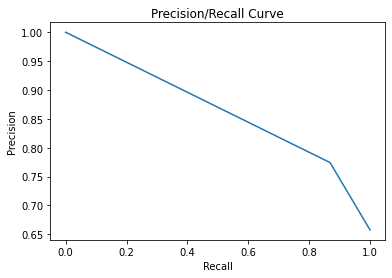

In [36]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
#from sklearn.utils.fixes import signature

plt.figure("P-R Curve")
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

p,r,t = precision_recall_curve(y_trues, y_preds)

plt.plot(r,p)
plt.show()

0.000000 0.000000 2.000000
0.486398 0.868599 1.000000
1.000000 1.000000 0.000000


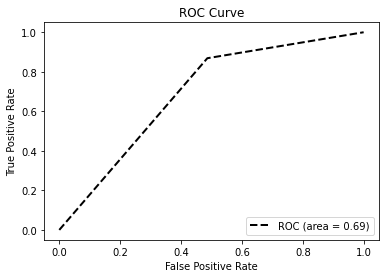

auc= 0.6911004582848961


In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thersholds = roc_curve(y_trues, y_preds, pos_label=1)
roc_auc = auc(fpr, tpr)
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))

plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
print("auc=",roc_auc)


In [49]:
model_dict=model.load_state_dict(torch.load("./statcktckt", map_location=torch.device('cpu')))


RuntimeError: Error(s) in loading state_dict for MODEL:
	size mismatch for init_memory_key: copying a param with shape torch.Size([50, 50]) from checkpoint, the shape in current model is torch.Size([20, 50]).
	size mismatch for init_memory_value: copying a param with shape torch.Size([50, 100]) from checkpoint, the shape in current model is torch.Size([20, 200]).
	size mismatch for read_embed_linear.weight: copying a param with shape torch.Size([50, 150]) from checkpoint, the shape in current model is torch.Size([50, 250]).
	size mismatch for mem.memory_key: copying a param with shape torch.Size([50, 50]) from checkpoint, the shape in current model is torch.Size([20, 50]).
	size mismatch for mem.memory_value: copying a param with shape torch.Size([10, 50, 100]) from checkpoint, the shape in current model is torch.Size([32, 20, 200]).
	size mismatch for mem.value_head.erase.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([200, 200]).
	size mismatch for mem.value_head.erase.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for mem.value_head.add.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([200, 200]).
	size mismatch for mem.value_head.add.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for q_embed.weight: copying a param with shape torch.Size([1224, 50]) from checkpoint, the shape in current model is torch.Size([111, 50]).
	size mismatch for qa_embed.weight: copying a param with shape torch.Size([2447, 100]) from checkpoint, the shape in current model is torch.Size([221, 200]).